In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import h5pyd
import pandas as pd
import windrose as wr
import astral

In [2]:
import rex

In [3]:
from mmctools.helper_functions import theta
from mmctools.helper_functions import T_to_Tv
from mmctools.plotting import plot_timehistory_at_height, plot_profile, plot_timeheight

In [4]:
# constants
k = 0.4      # von Karman constant
g = 9.81
Rd = 287.05  # gas constant for dry air [J kg^-1 K-1]
Cp = 1004.   # specific heat at constant pressure for dry air [J kg^-1 K-1]

# WIND Toolkit Analysis (updated dataset)
# Part 3 - Updrafts and Spring Variability

Regis Thedin \
Dec 2020

## - Read saved feather files

In [5]:
df20km = pd.read_feather(os.path.join('data','df20km.ftr')).set_index(['datetime','height'])
dfsc = pd.read_feather(os.path.join('data','dfsc.ftr')).set_index(['datetime','height'])
df20km = pd.read_feather(os.path.join('data','df20km.ftr')).set_index(['datetime','height'])
dfold = pd.read_feather(os.path.join('data','dfold.ftr')).set_index(['datetime','height'])
dfcasp = pd.read_feather(os.path.join('data','dfcasp.ftr')).set_index(['datetime'])

In [6]:
# Aux variables for plotting
dfnames = ['old WTK','single column','20x20 km avg','KCPR airport']
season_names = ['winter','spring','summer','fall']
month_names = ['','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# hours unique
hours_u = np.arange(0,24)

# heights where wind data are available for dfsc and df20km
heights_wind = np.concatenate((np.array([10]),np.arange(20,201,20)))
# unique heights
heights_u = df20km.index.levels[1]

# hub height for wind roses
zhub = 80

In [7]:
# Auxiliary windrose plots variables
rec2x2 = [[0,0.5,0.4,0.4],[0.5,0.5,0.4,0.4],[0,0,0.4,0.4],[0.5,0,0.4,0.4]]
rec4x1 = [[0.00,0.00,0.22,1],[0.25,0.00,0.22,1],[0.50,0.00,0.22,1],[0.75,0.00,0.22,1]]
rec4x2 = [[0.00,0.50,0.22,0.45],[0.25,0.50,0.22,0.45],[0.50,0.50,0.22,0.45],[0.75,0.50,0.22,0.45],\
          [0.00,0.00,0.22,0.45],[0.25,0.00,0.22,0.45],[0.50,0.00,0.22,0.45],[0.75,0.00,0.22,0.45]]
rec4x4 = [[0.00,0.75,0.22,0.22],[0.25,0.75,0.22,0.22],[0.50,0.75,0.22,0.22],[0.75,0.75,0.22,0.22],\
          [0.00,0.50,0.22,0.22],[0.25,0.50,0.22,0.22],[0.50,0.50,0.22,0.22],[0.75,0.50,0.22,0.22],\
          [0.00,0.25,0.22,0.22],[0.25,0.25,0.22,0.22],[0.50,0.25,0.22,0.22],[0.75,0.25,0.22,0.22],\
          [0.00,0.00,0.22,0.22],[0.25,0.00,0.22,0.22],[0.50,0.00,0.22,0.22],[0.75,0.00,0.22,0.22]]

bins=([0,2,4,6,8,10,12,14])

wrlabels = ['','NE','','NW','','SW','','SE']

In [8]:
# Copy wind direction info from zhub to 0m so it's easier to slice/loc dataframe with hfx information
df20km.loc[(slice(None),0),'dir'] = df20km.xs(zhub, level='height')['dir'].values

## 6. Thermal updrafts
Attempting to classify by thermal updrafts. The convective velocity for CBLs $w_*$ is given by
\begin{equation}
w_* = \left( \frac{g z_i \overline{(\theta'w')}_s}{\bar{\theta}} \right)^{1/3} 
\end{equation}

Greenhut and Khalsa (J. Clim. Appl. Meteorol., 1982) defined thermal updrafts and downdrafts as those parts of the data series that exceed a specific velocity threshold. Thermal updrafts are defined as that part of the data series in which the vertical velocity exceeds $0.56w_∗$, and thermal downdrafts are defined as that part of the data series in which the vertical velocity is less than $−0.40w_∗$. We do not have the vertical velocity of the velocity from the WTK though.


In [9]:
for df in df20km,dfsc:
    zi = df['z_i'].xs(0,level='height').values
    Tw = df['hfx_Kms'].xs(0,level='height').values
    Temp = df['thetav'].xs(2,level='height').values
    df['wstar'] = ((g*zi*Tw/Temp)**(1/3)).repeat(len(heights_u))

<ipython-input-9-abaf78a9a9be>:5: RuntimeWarning: invalid value encountered in power
  df['wstar'] = ((g*zi*Tw/Temp)**(1/3)).repeat(len(heights_u))


### 6.1. Estimate the mean vertical velocity in thermal updrafts
From Shannon et al, BLM 104 (2002): 167--199, "Measurements of Thermal Updraft Intensity Over Complex Terrain Using American White Pelicans and a Simple Boundary-Layer Forecast Model":

"For example, in examining a time series of vertical velocity data obtained from aircraft measurements, Young (1988) defined those parts of the data series with positive vertical velocities as thermal updrafts, while the remainder of the data series was classified as environmental downdraft. Young showed that the mean vertical velocity in thermal updrafts $\overline{w_T}}$ at some altitude $z$ can be approximated through the relationship,
\begin{equation}
\frac{\overline{w_T}}{w_*} = 0.85 \left( \frac{z}{z_i} \right)^{1/3} \left( 1.3 - \frac{z}{z_i} \right)
\end{equation}
where $z_i$ is the boundary-layer depth and $w_∗$ is the convective velocity scale"


In [10]:
for df in dfsc, df20km:
    zi = df['z_i'].xs(0,level='height').repeat(len(heights_u)).values
    z = df.reset_index()['height'].values
    #z = heights_u.repeat(len(heights_u))
    df['wT'] = df['wstar']*0.85*(z/zi)**(1/3)*(1.3-z/zi)

In [11]:
df20km['wT'].describe()

count    102284.000000
mean          0.472450
std           0.329076
min          -1.469659
25%           0.223055
50%           0.420717
75%           0.691391
max           1.461557
Name: wT, dtype: float64

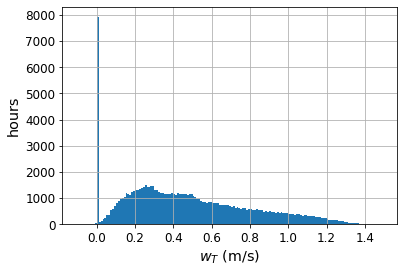

In [12]:
ax = df20km['wT'].hist(bins=np.arange(-0.1,1.5,0.01))
plt.tick_params(labelsize='large')
plt.xlabel(r'$w_T$ (m/s)',fontsize='x-large')
plt.ylabel(r'hours',fontsize='x-large')
plt.show()

count    992.000000
mean       0.587458
std        0.281534
min       -0.111346
25%        0.343732
50%        0.558070
75%        0.860780
max        1.108768
Name: wT, dtype: float64


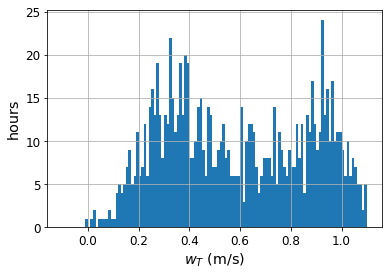

In [13]:
# Unstable, daytime, W winds
cond = ((df20km['dir']=='W') & (df20km['hour']>=6) & (df20km['hour']<18) & ((df20km['stability']=='U')|(df20km['stability']=='VU')))
updraft = df20km.loc[cond]['wT'].xs(zhub,level='height')
print(updraft.describe())

ax = updraft.hist(bins=np.arange(-0.1,1.1,0.01))
plt.tick_params(labelsize='large')
plt.xlabel(r'$w_T$ (m/s)',fontsize='x-large')
plt.ylabel(r'hours',fontsize='x-large')
plt.show()

### 6.2. Wind roses with data exceding updraft threshold
Now, let's go back to the wind roses and use only data related to those scenarios where the threshold of 0.85 m/s has been exceeded

In [14]:
aboveThreshold = df20km.loc[df20km['wT']>=0.85]

array([[<AxesSubplot:title={'center':'inverseL_2m'}>,
        <AxesSubplot:title={'center':'pressure'}>,
        <AxesSubplot:title={'center':'RH_2m'}>,
        <AxesSubplot:title={'center':'temperature'}>],
       [<AxesSubplot:title={'center':'tke'}>,
        <AxesSubplot:title={'center':'winddirection'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'thetav'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'zoverL_2m'}>],
       [<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'wstar'}>,
        <AxesSubplot:title={'center':'wT'}>, <AxesSubplot:>]],
      dtype=object)

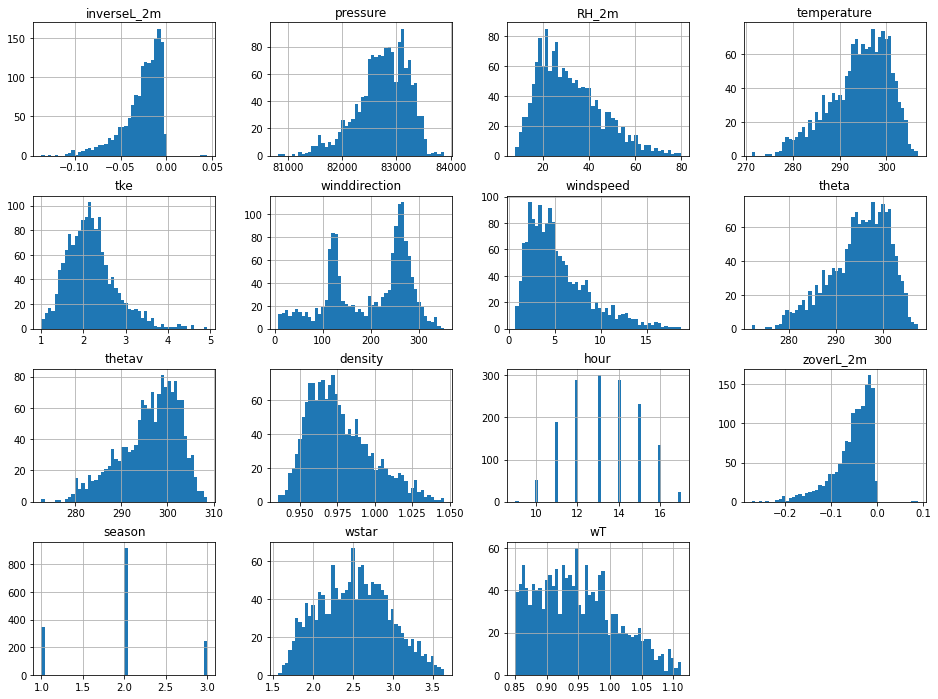

In [15]:
aboveThreshold.xs(zhub,level='height').hist([ 'inverseL_2m',
                     'pressure','RH_2m', 
                     'temperature', 'tke','winddirection', 'windspeed', 'theta',
                     'thetav', 'density', 'dir', 'hour',
                     'zoverL_2m',  'stability','season', 'wstar', 'wT'],figsize=(16,12),bins=50)

<AxesSubplot:>

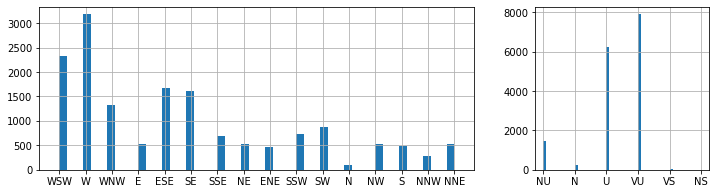

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,3), gridspec_kw={'width_ratios': [2.5, 1]})

aboveThreshold['dir'].hist(bins=50,ax=axs[0])
aboveThreshold['stability'].hist(bins=50, ax=axs[1])

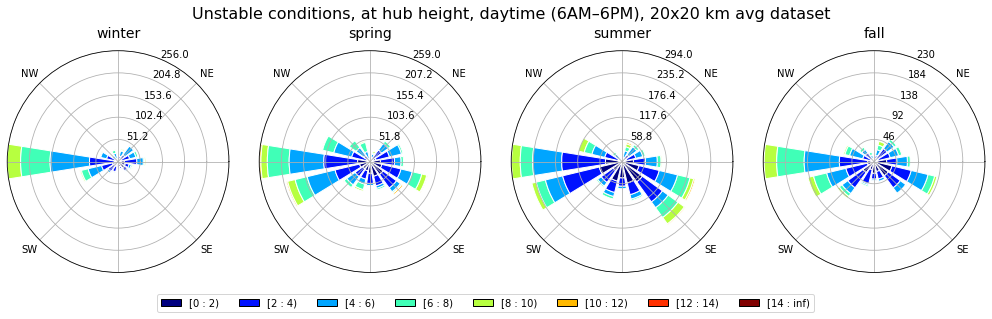

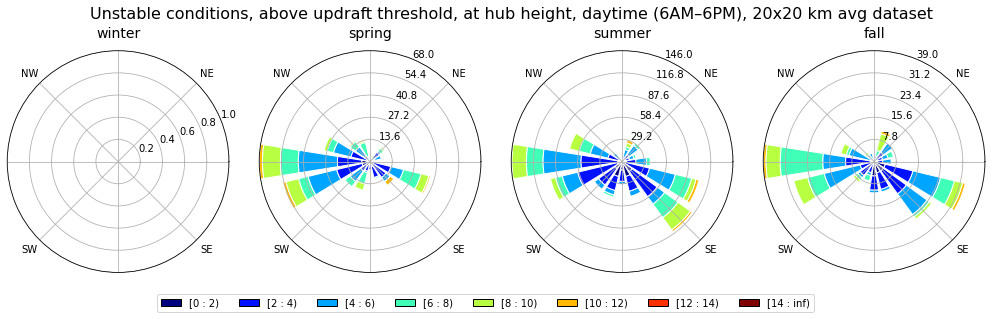

In [17]:
df=df20km

# Unstable, 20x20 dataset
fig = plt.figure(figsize=(14,5))
fig.suptitle('Unstable conditions, at hub height, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for s in range(4):
    wa = wr.WindroseAxes(fig, rec4x1[s])
    fig.add_axes(wa)
    cond = ((df['season']==s) & (df['hour']>=6) & (df['hour']<18) & ((df['stability']=='U')|(df['stability']=='VU')))# & (df['wT']>=0.85))
    ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
    wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
    wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{season_names[s]}',fontsize=14, y=1.03)
wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))
plt.show()
print('\n\n')


fig = plt.figure(figsize=(14,5))
fig.suptitle('Unstable conditions, above updraft threshold, at hub height, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for s in range(4):
    wa = wr.WindroseAxes(fig, rec4x1[s])
    try:
        fig.add_axes(wa)
        cond = ((df['season']==s) & (df['hour']>=6) & (df['hour']<18) & ((df['stability']=='U')|(df['stability']=='VU')) & (df['wT']>=0.85))
        ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
        wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
        wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    except KeyError:
        pass
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{season_names[s]}',fontsize=14, y=1.03)
wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))
plt.show()

### 6.3. Back at heat flux when updrafts are above the threshold

Text(0.5, 1.0, 'heat flux: above threshold, W winds, U/VU states, Daytime, 20x20 km dataset')

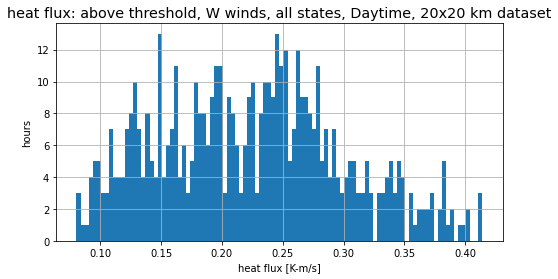

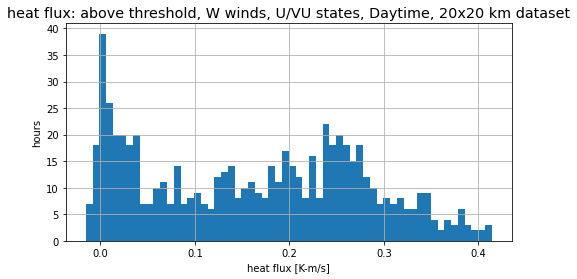

In [18]:
# heat flux, above threshold, all states, W winds only
cond = ((df20km['dir']=='W') & (df20km['hour']>=6) & (df20km['hour']<18) & (df20km['wT']>=0.85))
positions = df20km.loc[cond]
heatflux = df20km.loc[(positions.index.get_level_values("datetime"), 0),'hfx_Kms']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax = heatflux.hist(bins=100)
ax.set_xlabel('heat flux [K-m/s]')
ax.set_ylabel('hours')
ax.set_title(r'heat flux: above threshold, W winds, all states, Daytime, 20x20 km dataset', fontsize='x-large')

# heat flux, above threshold, U/VS states, W winds
cond = (df20km['dir']=='W') & (df20km['hour']>=6) & (df20km['hour']<18) & ((df20km['stability']=='U')|(df20km['stability']=='VU') & (df20km['wT']>=0.85))
positions = df20km.loc[cond]
heatflux = df20km.loc[(positions.index.get_level_values("datetime"), 0),'hfx_Kms']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))
ax = heatflux.hist(bins=60)
ax.set_xlabel('heat flux [K-m/s]')
ax.set_ylabel('hours')
ax.set_title(r'heat flux: above threshold, W winds, U/VU states, Daytime, 20x20 km dataset', fontsize='x-large')

### 6.4. Spring variation

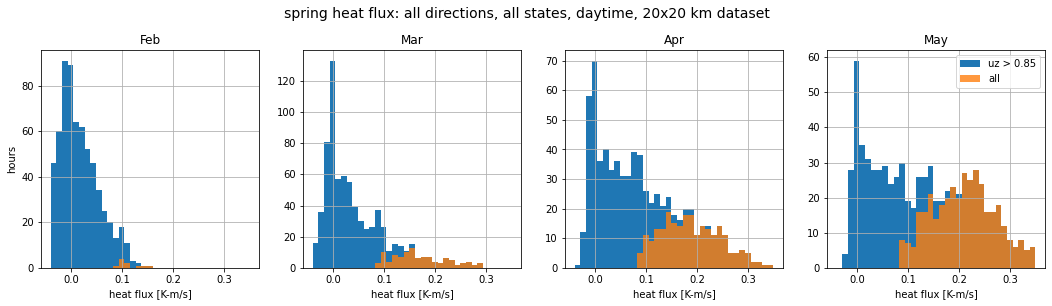

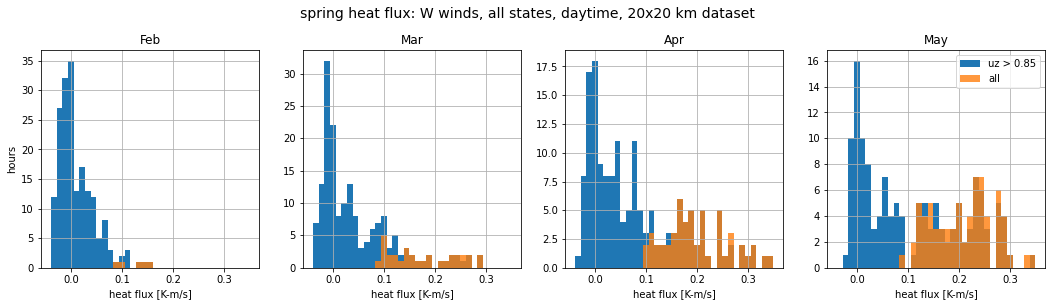

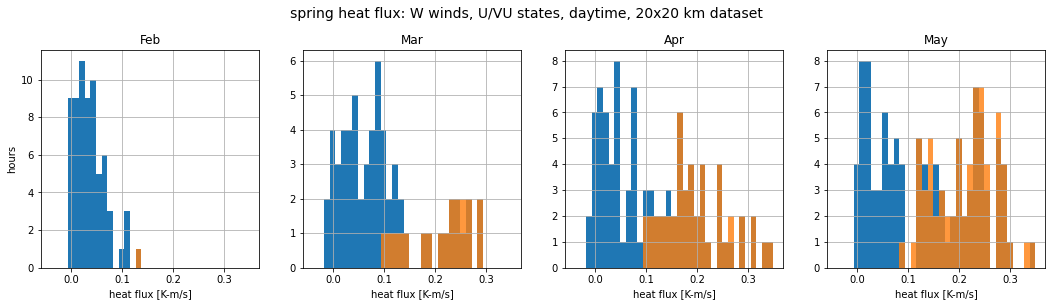

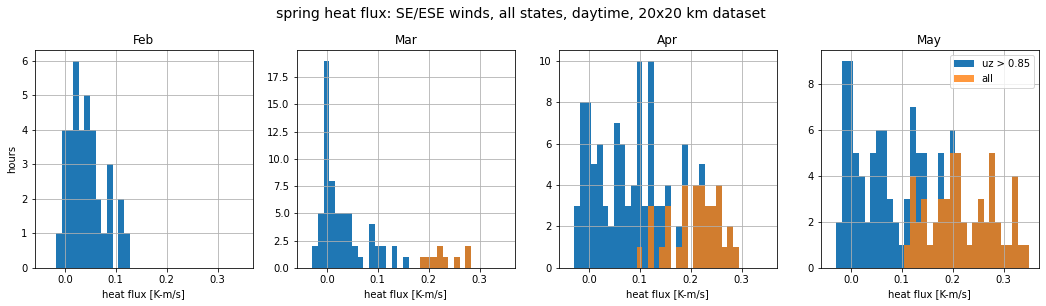

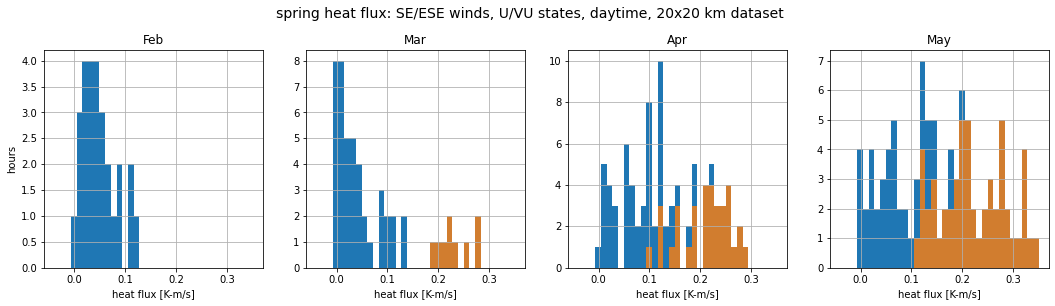

In [19]:
nBins=35
alpha=0.8
histrange=[-0.04, 0.35]

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,4))
fig.suptitle(r'spring heat flux: all directions, all states, daytime, 20x20 km dataset', fontsize='14',  y=1.03)
for i,m in enumerate([2,3,4,5]):
    # heat flux, W winds, all states, daytime
    cond = ((df20km['hour']>=6) & (df20km['hour']<18) & (df20km['month']==m))
    heatflux = df20km.loc[cond]['hfx_Kms'].xs(0,level='height')
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i])
    # above threshold
    positions = df20km.loc[cond & (df20km['wT']>=0.85)]
    heatflux = df20km.loc[(positions.index.get_level_values("datetime"), 0),'hfx_Kms']
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i], alpha=alpha)
    axs[i].set_xlabel('heat flux [K-m/s]')
    axs[i].set_title(f'{month_names[m]}',fontsize=12)#, y=1.03)
axs[0].set_ylabel('hours')
axs[3].legend({'all','uz > 0.85'})
plt.show()
print('\n')

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,4))
fig.suptitle(r'spring heat flux: W winds, all states, daytime, 20x20 km dataset', fontsize='14',  y=1.03)
for i,m in enumerate([2,3,4,5]):
    # heat flux, W winds, all states, daytime
    cond = ((df20km['dir']=='W') & (df20km['hour']>=6) & (df20km['hour']<18) & (df20km['month']==m))
    heatflux = df20km.loc[cond]['hfx_Kms'].xs(0,level='height')
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i])
    # above threshold
    positions = df20km.loc[cond & (df20km['wT']>=0.85)]
    heatflux = df20km.loc[(positions.index.get_level_values("datetime"), 0),'hfx_Kms']
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i], alpha=alpha)
    axs[i].set_xlabel('heat flux [K-m/s]')
    axs[i].set_title(f'{month_names[m]}',fontsize=12)#, y=1.03)
axs[0].set_ylabel('hours')
axs[3].legend({'all','uz > 0.85'})
plt.show()
print('\n')


fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,4))
fig.suptitle(r'spring heat flux: W winds, U/VU states, daytime, 20x20 km dataset', fontsize='14',  y=1.03)
for i,m in enumerate([2,3,4,5]):
    # heat flux, W winds, U/VU states, daytime
    cond = ((df20km['dir']=='W') & (df20km['hour']>=6) & (df20km['hour']<18) & ((df20km['stability']=='U')|(df20km['stability']=='VU'))  & (df20km['month']==m) )
    heatflux = df20km.loc[cond]['hfx_Kms'].xs(0,level='height')
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i])
    # above threshold
    positions = df20km.loc[cond & (df20km['wT']>=0.85)]
    heatflux = df20km.loc[(positions.index.get_level_values("datetime"), 0),'hfx_Kms']
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i], alpha=alpha)
    axs[i].set_xlabel('heat flux [K-m/s]')
    axs[i].set_title(f'{month_names[m]}',fontsize=12)#, y=1.03)
axs[0].set_ylabel('hours')
plt.show()


fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,4))
fig.suptitle(r'spring heat flux: SE/ESE winds, all states, daytime, 20x20 km dataset', fontsize='14',  y=1.03)
for i,m in enumerate([2,3,4,5]):
    # heat flux, W winds, all states, daytime
    cond = ( ((df20km['dir']=='SE')|(df20km['dir']=='ESE')) & (df20km['hour']>=6) & (df20km['hour']<18) & (df20km['month']==m))
    heatflux = df20km.loc[cond]['hfx_Kms'].xs(0,level='height')
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i])
    # above threshold
    positions = df20km.loc[cond & (df20km['wT']>=0.85)]
    heatflux = df20km.loc[(positions.index.get_level_values("datetime"), 0),'hfx_Kms']
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i], alpha=alpha)
    axs[i].set_xlabel('heat flux [K-m/s]')
    axs[i].set_title(f'{month_names[m]}',fontsize=12)#, y=1.03)
axs[0].set_ylabel('hours')
axs[3].legend({'all','uz > 0.85'})
plt.show()
print('\n')


fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18,4))
fig.suptitle(r'spring heat flux: SE/ESE winds, U/VU states, daytime, 20x20 km dataset', fontsize='14',  y=1.03)
for i,m in enumerate([2,3,4,5]):
    # heat flux, W winds, U/VU states, daytime
    cond = ( ((df20km['dir']=='SE')|(df20km['dir']=='ESE')) & (df20km['hour']>=6) & (df20km['hour']<18) & ((df20km['stability']=='U')|(df20km['stability']=='VU'))  & (df20km['month']==m) )
    heatflux = df20km.loc[cond]['hfx_Kms'].xs(0,level='height')
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i])
    # above threshold
    positions = df20km.loc[cond & (df20km['wT']>=0.85)]
    heatflux = df20km.loc[(positions.index.get_level_values("datetime"), 0),'hfx_Kms']
    heatflux.hist(bins=nBins, range=histrange, ax=axs[i], alpha=alpha)
    axs[i].set_xlabel('heat flux [K-m/s]')
    axs[i].set_title(f'{month_names[m]}',fontsize=12)#, y=1.03)
axs[0].set_ylabel('hours')
plt.show()

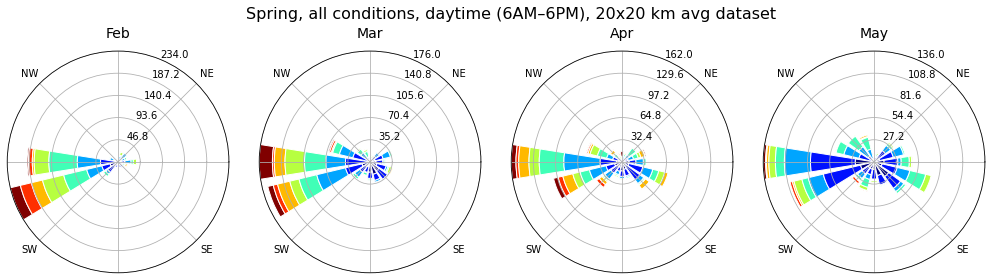

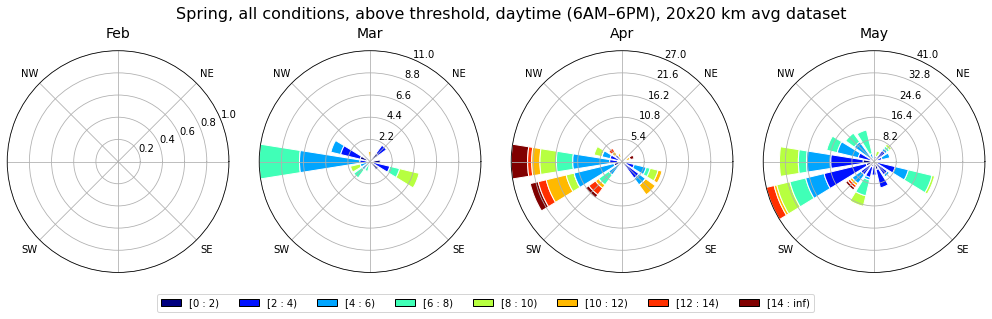

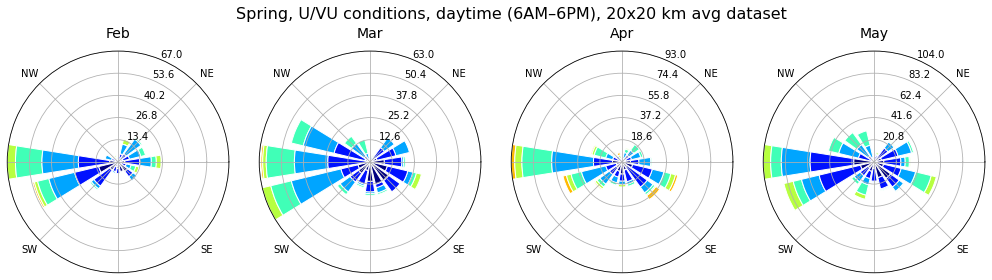

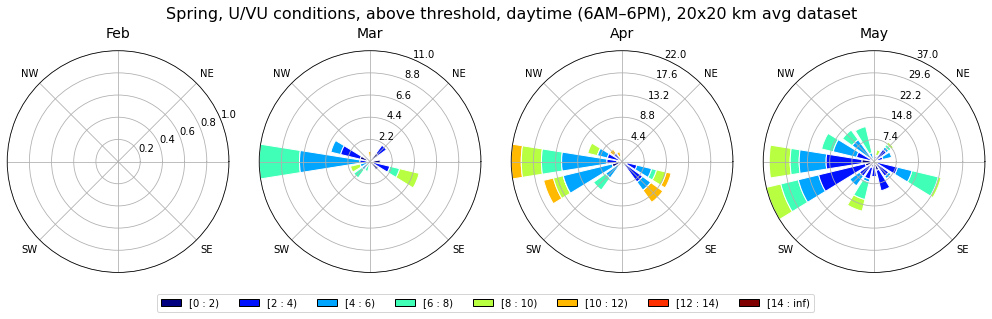

In [20]:
df=df20km

# all conditions, 20x20 dataset
fig = plt.figure(figsize=(14,5))
fig.suptitle('Spring, all conditions, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for i,m in enumerate([2,3,4,5]):
    wa = wr.WindroseAxes(fig, rec4x1[i])
    fig.add_axes(wa)
    try:
        cond = ((df['month']==m) & (df['hour']>=6) & (df['hour']<18) )# & (df['wT']>=0.85))
        ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
        wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
        wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    except KeyError:
        pass
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{month_names[m]}',fontsize=14, y=1.03)
plt.show()
fig = plt.figure(figsize=(14,5))
fig.suptitle('Spring, all conditions, above threshold, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for i,m in enumerate([2,3,4,5]):
    wa = wr.WindroseAxes(fig, rec4x1[i])
    try:
        fig.add_axes(wa)
        cond = ((df['month']==m) & (df['hour']>=6) & (df['hour']<18) & (df['wT']>=0.85))
        ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
        wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
        wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    except KeyError:
        pass
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{month_names[m]}',fontsize=14, y=1.03)
wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))
plt.show()
print('\n\n')


# unstable conditions, 20x20 dataset
fig = plt.figure(figsize=(14,5))
fig.suptitle('Spring, U/VU conditions, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for i,m in enumerate([2,3,4,5]):
    wa = wr.WindroseAxes(fig, rec4x1[i])
    try:
        fig.add_axes(wa)
        cond = ((df['month']==m) & (df['hour']>=6) & (df['hour']<18) & ((df['stability']=='U')|(df['stability']=='VU')))# & (df['wT']>=0.85))
        ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
        wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
        wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    except KeyError:
        pass
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{month_names[m]}',fontsize=14, y=1.03)
plt.show()
fig = plt.figure(figsize=(14,5))
fig.suptitle('Spring, U/VU conditions, above threshold, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for i,m in enumerate([2,3,4,5]):
    wa = wr.WindroseAxes(fig, rec4x1[i])
    fig.add_axes(wa)
    try:  
        cond = ((df['month']==m) & (df['hour']>=6) & (df['hour']<18) & ((df['stability']=='U')|(df['stability']=='VU')) & (df['wT']>=0.85))
        ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
        wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values 
        wa.bar(wd, ws,bins=bins, opening=0.8, edgecolor='white')
    except KeyError:
        pass
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{month_names[m]}',fontsize=14, y=1.03)
wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))
plt.show()
print('\n\n')

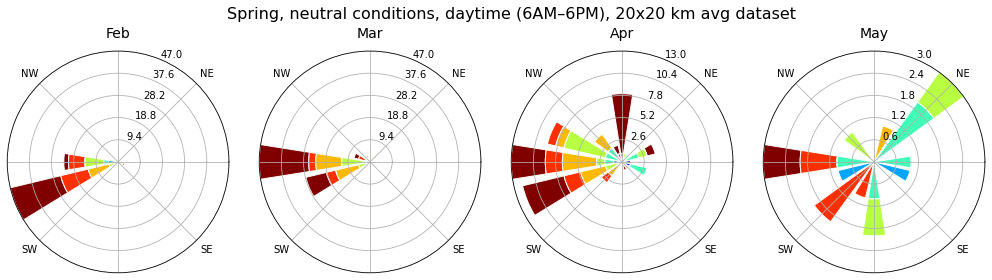

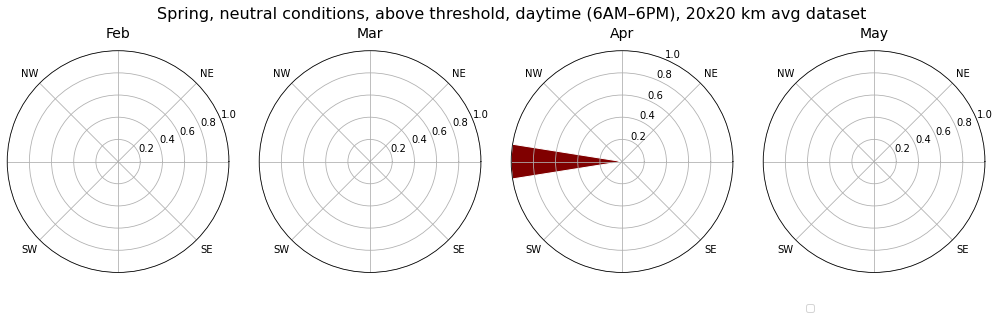

In [21]:
# neutral conditions, 20x20 dataset
fig = plt.figure(figsize=(14,5))
fig.suptitle('Spring, neutral conditions, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for i,m in enumerate([2,3,4,5]):
    wa = wr.WindroseAxes(fig, rec4x1[i])
    try:
        fig.add_axes(wa)
        cond = ((df['month']==m) & (df['hour']>=6) & (df['hour']<18) & (df['stability']=='N'))# & (df['wT']>=0.85))
        ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
        wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values   
        wa.bar(wd, ws, bins=bins, opening=0.8, edgecolor='white')
    except KeyError:
        pass
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{month_names[m]}',fontsize=14, y=1.03)
plt.show()
fig = plt.figure(figsize=(14,5))
fig.suptitle('Spring, neutral conditions, above threshold, daytime (6AM–6PM), 20x20 km avg dataset', y=0.93, fontsize=16)
for i,m in enumerate([2,3,4,5]):
    wa = wr.WindroseAxes(fig, rec4x1[i])
    fig.add_axes(wa)
    try: 
        cond = ((df['month']==m) & (df['hour']>=6) & (df['hour']<18) & (df['stability']=='N') & (df['wT']>=0.85))
        ws = df.loc[cond].xs(zhub, level='height')['windspeed'].values
        wd = df.loc[cond].xs(zhub, level='height')['winddirection'].values 
        wa.bar(wd, ws,bins=bins, opening=0.8, edgecolor='white')
    except KeyError:
        pass
    wa.set_xticklabels(wrlabels)
    wa.set_title(f'{month_names[m]}',fontsize=14, y=1.03)
wa.legend(loc='lower right',decimal_places=0,labelspacing=0.7,bbox_to_anchor=(0.25,-0.2),ncol=len(bins))
plt.show()
print('\n\n')

[Text(0, 0, '0')]

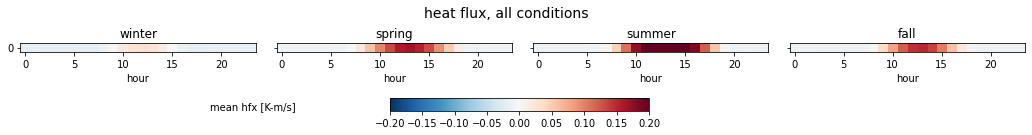

In [22]:
# Wind speed over the seasons, at every height for every hour
zcomp = 0

fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(18,1.2))
fig.suptitle('heat flux, all conditions',fontsize=14)
fig.subplots_adjust(hspace=0.18, wspace=0.09)


seasonaldata = df20km.groupby(['season','hour','height']).mean()
for s in range(4):
    ws = np.zeros(shape=(1,len(hours_u)))
    for (j,h) in enumerate(hours_u): 
        try:
            ws[0,j] = seasonaldata.loc[(s,h,zcomp)]['hfx_Kms']    
        except KeyError:
            ws[0,j] = np.nan
    p = ax[s].imshow(ws[:,:], origin='lower',vmin=-0.2, vmax=0.2, cmap='RdBu_r')
    ax[s].set_title(f'{season_names[s]}')

# set titles, labels and colorbar
cb_ax = fig.add_axes([0.41,-0.23,0.2, 0.15]);  cbar = fig.colorbar(p, cax = cb_ax, orientation='horizontal') 
cb_ax.set_ylabel('mean hfx [K-m/s]',labelpad=180, rotation=0, loc='bottom')


for axi in ax:
    axi.set_xlabel('hour')

ax[0].set_yticks([0])
ax[0].set_yticklabels([zcomp])